In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader

from src.models import TopologicallyRegularizedAutoencoder
from src.datasets.manifolds import SwissRoll, SCurve, Spheres

#from src.datasets.splitting import split_dataset

torch.manual_seed(42)
np.random.seed(42)

In [7]:
train=True
dataset = Spheres(train=train)

In [2]:
#older func we used for this datasets:
def get_latent_space(model, dataloader):
    torch.manual_seed(42)
    
    full_latent_space = []
    all_labels = []

    for index, batch in enumerate(dataloader):
        data, label = batch
        latent = model.encode(data)
        reconst = model.decode(latent)
        latent = latent.detach().numpy()        
        reconst = reconst.detach().numpy()

        full_latent_space.append(latent)
        all_labels.append(label)

    full_latent_space = np.concatenate(full_latent_space, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return [full_latent_space, all_labels]

In [17]:
from src.evaluation.utils import get_space

batch_size = 64
# LOAD ALL MODELS AND GET SPACES
methods = ['topo_pure', 'topo_vertex', 'topo_edge', 'surrogate', 'vanilla']
datasets = ['swissroll', 'scurve']

#older runs: all 50 epochs
run_ids = [2,4,5,6,12,7,8,9,10,11] #ids mapping above method+dataset to run directory

#newer runs: swissroll on 200 epochs:
new_run_ids = [3,4,5,1,2] #for 200epochs..

run_index = 0 # points to current run in run_ids
path = '../runs/synthetic_experiments/{}/model.pth'
new_path = '../runs/synthetic_experiments/200_epochs/{}/model.pth'
train=True #False

# LOAD DATASETS:
datasets_ = {datasets[0]: SwissRoll(train=train), datasets[1]: SCurve(train=train)}

experiments = defaultdict(lambda: defaultdict(dict))
#Gathering all paths in one dict of dicts:
for dataset in datasets:
    
    #define dataloader:
    dataloader = DataLoader(datasets_[dataset], batch_size=batch_size, shuffle=False,
            pin_memory=True, drop_last=True)
    
    experiments[dataset]['data_space'] = get_space(None, dataloader, mode='data')[0]
    
    for method in methods:
        #init dict:
        #experiments[dataset][method] = {}
        
        #determine current model path:
        if dataset == 'swissroll':
            curr_path = new_path.format(new_run_ids[run_index])
        else:
            curr_path = path.format(run_ids[run_index])
        model = torch.load(curr_path)
        
        #Keep path, model, and latent space in dict:
        experiments[dataset][method]['path'] = curr_path 
        experiments[dataset][method]['model'] = model
        
        latent, labels = get_space(model, dataloader, mode='latent')
        
        experiments[dataset][method]['latent'] = latent
        experiments[dataset][method]['labels'] = labels
        
        
        
        run_index+=1

In [74]:
experiments['scurve'][methods[0]]['latent']

array([[0.8124404 , 1.2773142 ],
       [0.71396816, 0.86703336],
       [0.50402963, 1.2201953 ],
       ...,
       [0.37960696, 0.5470642 ],
       [0.90545046, 0.42599922],
       [1.376031  , 0.7667154 ]], dtype=float32)

In [50]:
n_samples = 10000

In [6]:
def plotting(transformed, all_labels, title):
    plt.scatter(transformed[:, 0], transformed[:, 1], c=all_labels, cmap=plt.cm.Spectral)
    plt.title(title)

def plott_all(dataset_name, X,labels, methods, all_Z):
    fig = plt.figure(1)
    ax = fig.add_subplot(321, projection="3d")
    
    #Plot Swiss Roll Data:
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Spectral)

    plt.xticks([]), plt.yticks([])
    myfontsize = 18
    plt.title(dataset_name, fontsize=myfontsize)
    ax.set_xlabel('x', fontsize=myfontsize)
    ax.set_ylabel('y', fontsize=myfontsize)
    ax.set_zlabel('z', fontsize=myfontsize)
    fig.set_size_inches(12, 12)
    ax.view_init(5, 280) # rotation of the 3D plot
    plt.show()
    
    #subplot_count = 2
    #for method, latent in zip(methods, all_Z):
    #add subplots for latent spaces:
    ax = fig.add_subplot(322)
    plotting(all_Z[0], labels, f'2D Latent Space {methods[0]}')
    
    ax = fig.add_subplot(323)
    plotting(all_Z[1], labels, f'2D Latent Space {methods[1]}')
    
    ax = fig.add_subplot(324)
    plotting(all_Z[2], labels, f'2D Latent Space {methods[2]}')

    ax = fig.add_subplot(325)
    plotting(all_Z[3], labels, f'2D Latent Space {methods[3]}')
    
    ax = fig.add_subplot(326)
    plotting(all_Z[4], labels, f'2D Latent Space {methods[4]}')
    
    

<IPython.core.display.Javascript object>


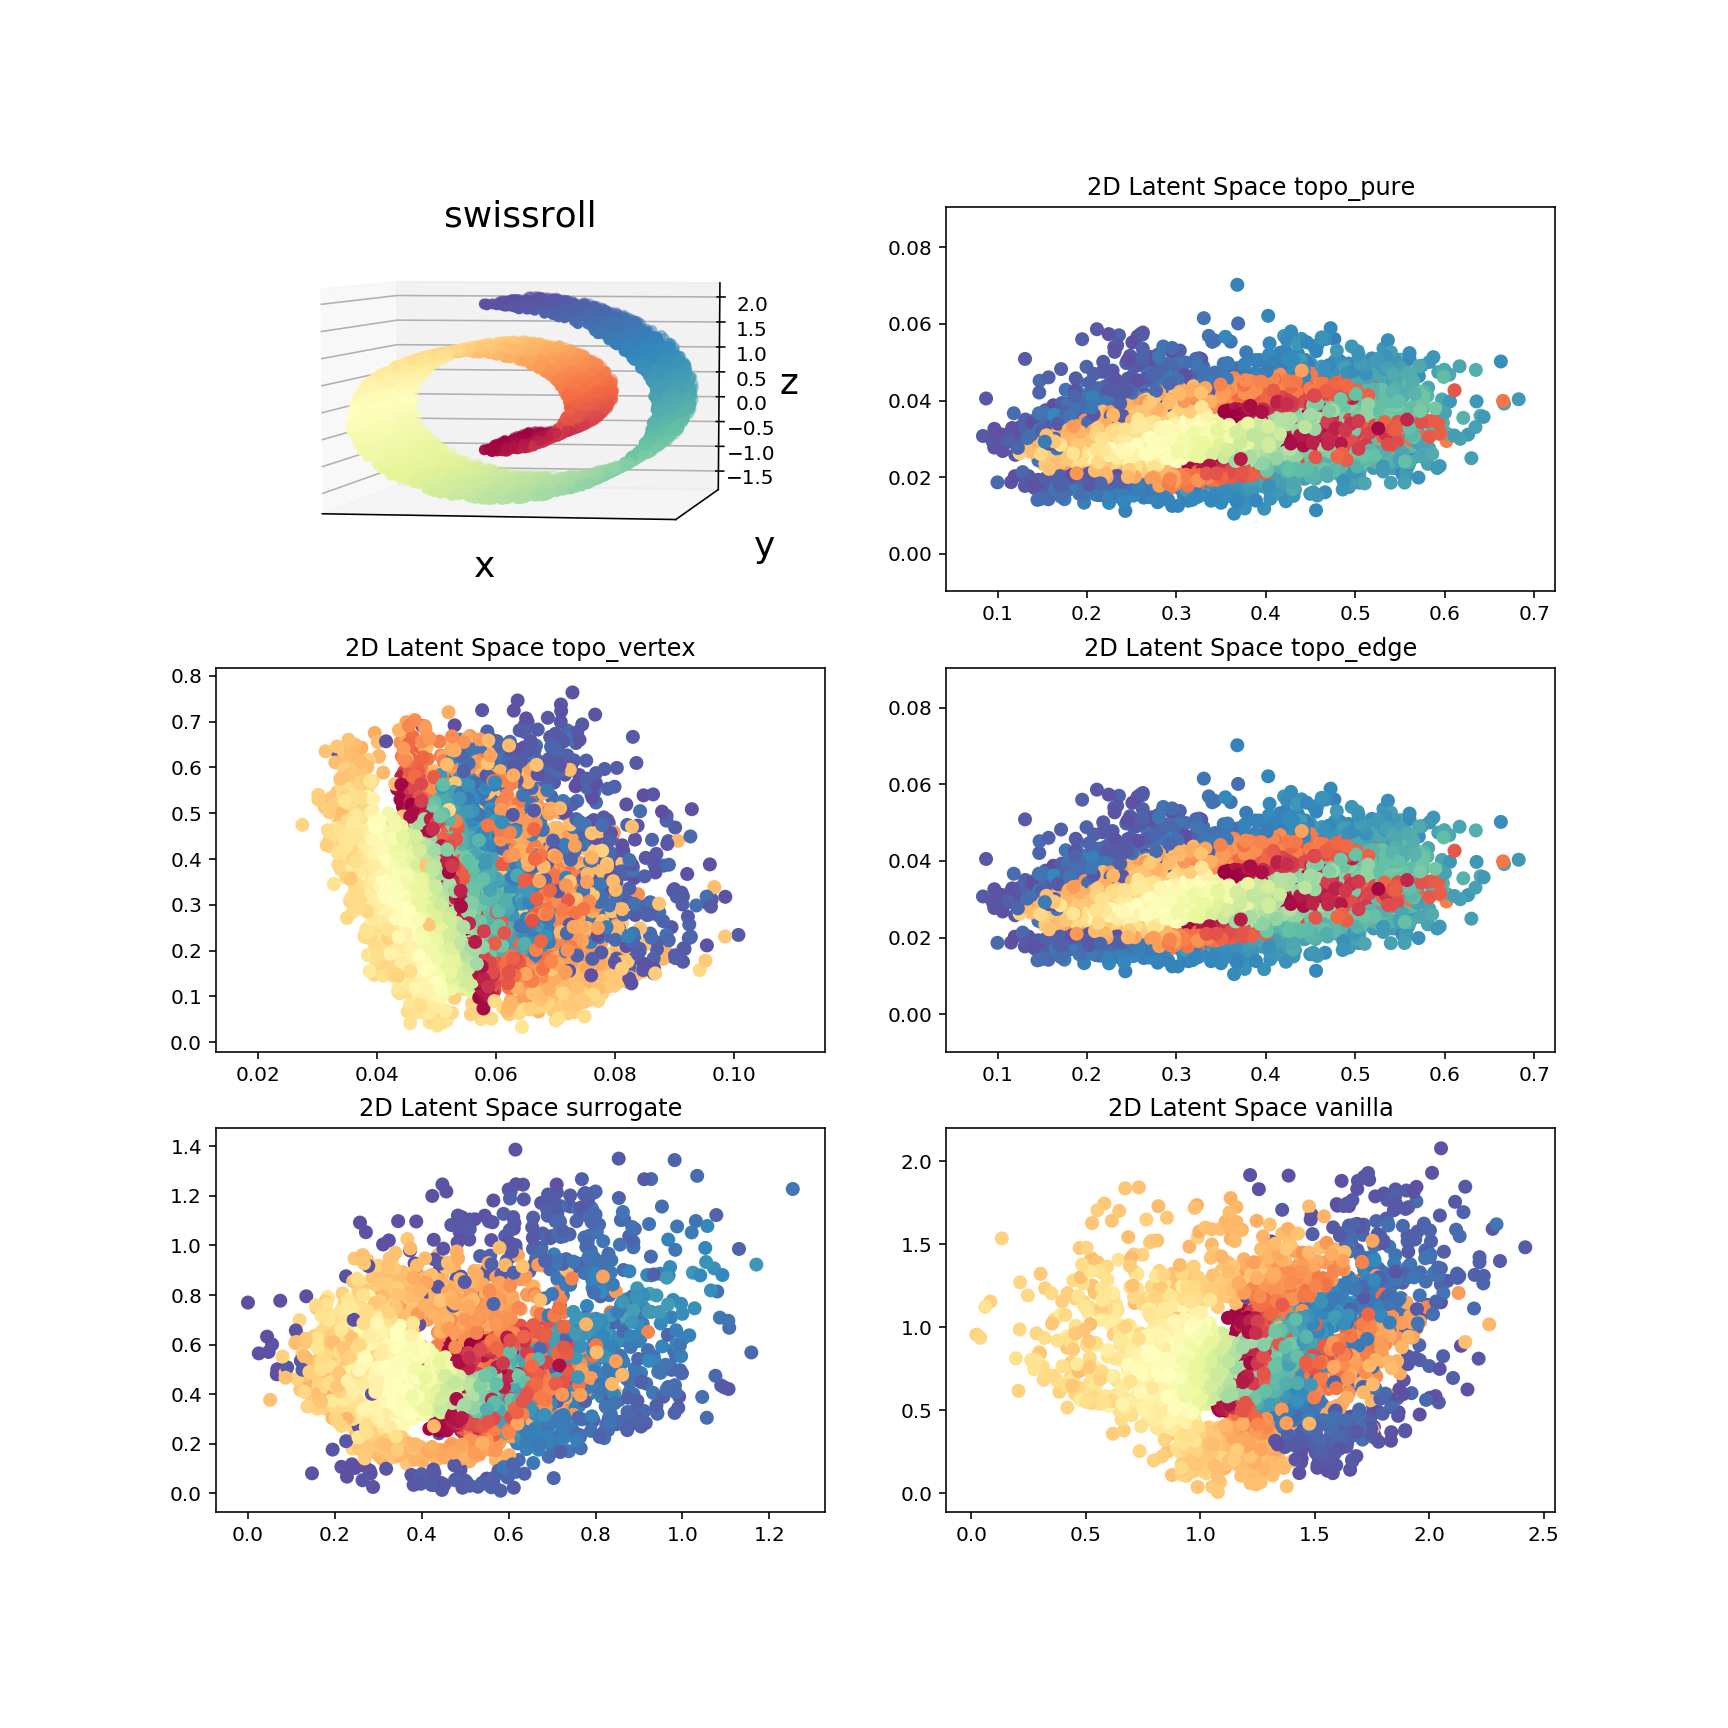

In [18]:
%matplotlib notebook

dataset= 'swissroll' #'scurve'
methods = ['topo_pure', 'topo_vertex', 'topo_edge', 'surrogate', 'vanilla']
    
X = experiments[dataset]['data_space']
labels = experiments[dataset][methods[0]]['labels']

all_Z = [experiments[dataset][method]['latent'] for method in methods]

#Z2 = experiments[dataset][methods[4]]['latent']

plott_all(dataset, X, labels, methods, all_Z)
plt.savefig('200_epochs_swissroll_train.png')

In [20]:
len(all_Z)

5